# Final Project: High-dynamic range imaging

Contributors 
+ *Zichuan Fan*  20809956 : Version1.0 of PartI step1, skeleton of PartI, Modularity
+ *Zhang,Yaonan* 20809952 : Rewrite PartI step1, PartI step2&3, PartII

### Implement Debevec-Malik method, e.g. see section 10.2 in Szeliski's book for details. You can use examples from here. Once you test your implementation on bracketed image sequences taken on a tripod, you can try to extend your method to multi-exposure images taken without a tripod using homography-based registration of the sequence. Can you drop the assumption that exposure is known?

## Part1 Implement Debevec-Malik method

#### Step 1
Estimate the radiometric response function

In [19]:
%matplotlib notebook

import numpy as np
import random
import numpy.linalg as la
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt

In [9]:
def MySampleIntensities(images,Z_min,Z_max):
    
    num_intensities = Z_max - Z_min + 1
    num_images = len(images)
    SN = 5 # how many sample for each inten
    intensity_values = np.zeros((num_intensities*SN, num_images), dtype=np.uint8)

    # Find the middle image to use as the source for pixel intensity locations
    mid_img = images[num_images // 2]

    k = 0
    for i in range(Z_min, Z_max + 1):
        rows, cols = np.where(mid_img == i)
        if(len(rows)):
            cnt = min(SN, len(rows))
            idxs = np.random.choice(len(rows),cnt,replace=False)
            for i in idxs:
                intensity_values[k] = images[:,rows[i], cols[i]]
                k +=1
    return intensity_values[:k,:]

def gslove(Z,B,l,w,Z_min,Z_max): # Based on Debevec and Malik's 21 line MATLAB
    n = Z_max - Z_min +1
    A = np.zeros((Z.shape[0]*Z.shape[1]+n, Z.shape[0]+n))
    b = np.zeros((A.shape[0],1))
    k = 0 
    # Include the data−fitting equations
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            wij = w[Z[i,j]]
            A[k,Z[i,j]] = wij; A[k,n+i] = -wij; b[k] = wij*B[j]
            k += 1
    # Fix the curve by setting its middle value to 0
    A[k,n//2] = 1
    k+=1
    # Include the smoothness equations
    
    for i in range(n-1):
        A[k,i:i+3] = l * w[i+1] * np.array([1,-2,1])
        k+=1
    print(A.shape)
    # Solve the system
    x = np.linalg.lstsq(A,b)[0]
    print(A.shape,b.shape,x.shape)
    print(k)
    
    g = x[0:n,0]
    lE = x[n:,0]
    
    return (g,lE)

(3, 580, 870, 3)


<IPython.core.display.Javascript object>


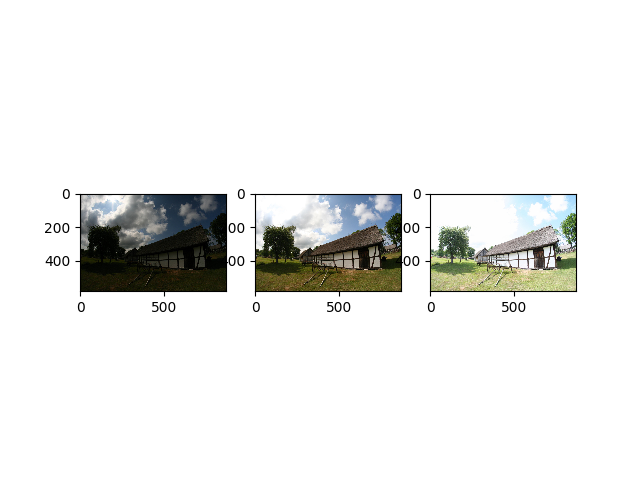

(4096, 1536)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


(4096, 1536) (4096, 1) (1536, 1)
4096


<IPython.core.display.Javascript object>


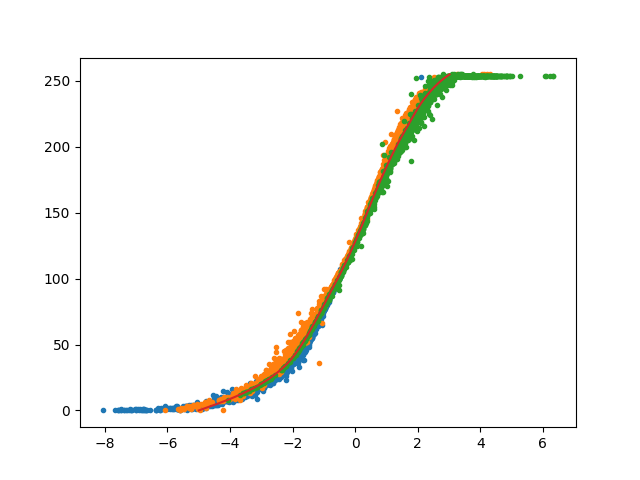

??? (256,)
(4096, 1536)
(4096, 1536) (4096, 1) (1536, 1)
4096


<IPython.core.display.Javascript object>


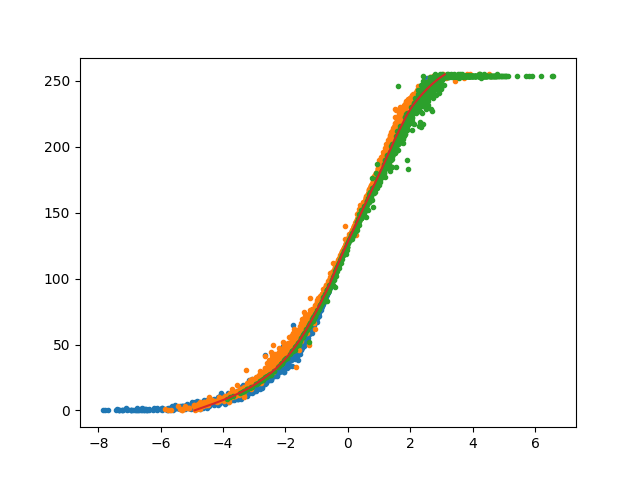

??? (256,)
(4096, 1536)
(4096, 1536) (4096, 1) (1536, 1)
4096


<IPython.core.display.Javascript object>


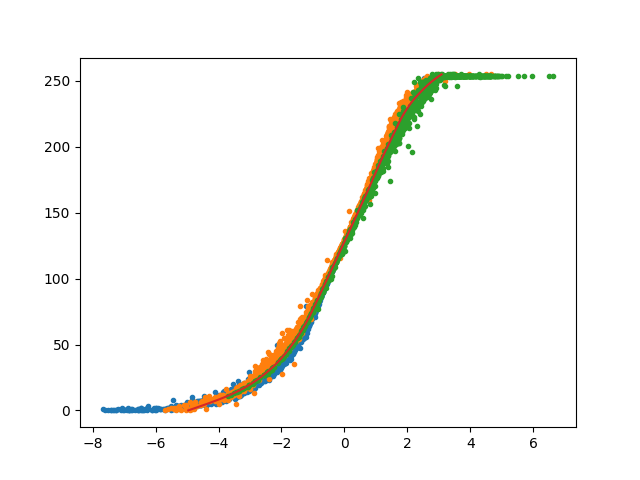

??? (256,)


In [10]:
imgs = np.array([
    image.imread("images/Kluki_-2.jpg"),
    image.imread("images/Kluki_0.jpg"),
    image.imread("images/Kluki_2.jpg"),
])
lT = log_exposure_time = np.array([-2,0,2])

print(imgs.shape)
n = imgs.shape[0]
ih = imgs.shape[1]
iw = imgs.shape[2]
isize = ih * iw
channel = imgs.shape[3]

plt.figure(0)
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.imshow(imgs[i])

z_min = 0
z_max = 255
w = np.array(range(z_max+1))
w = np.minimum(w-z_min, z_max-w)
gs = np.zeros((channel,z_max-z_min+1))

for c in range(channel):
    sample = MySampleIntensities(imgs[:,:,:,0],z_min,z_max)
    g,lE = gslove(sample,log_exposure_time, 128., w, z_min, z_max )
    plt.figure(c+1)
    for j in range(sample.shape[1]):
        plt.plot(lE+log_exposure_time[j],sample[:,j],'.')
    
    plt.plot(g,range(g.shape[0]))
    print('???',g.shape)
    gs[c] = g

plt.show()

### Step2
select pixels and estimate a radiance map

In [11]:
result = np.zeros((ih,iw,channel))

for c in range(channel):
    g = gs[c]

    logE = np.zeros((ih,iw))
    ww = np.exp(g) / np.gradient(g)

    for x in range(ih):
        for y in range(iw):
            logE[x,y] = ((ww[imgs[:,x,y,c]] * g[imgs[:,x,y,c]] - lT)).sum() / ww[imgs[:,x,y,c]].sum()
    result[:,:,c] = logE

### step 3
from $\log E_i$ to image

<IPython.core.display.Javascript object>


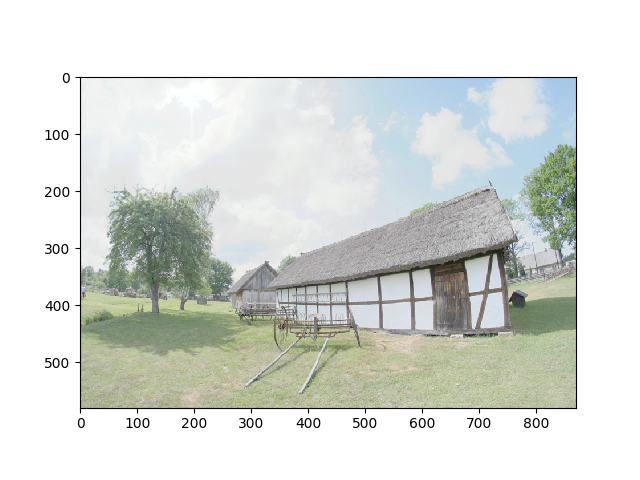

In [12]:
plt.figure(channel+1)

result1 = result - result.min()
result1 *= 255. / result1.max()

plt.imshow(result1.astype(np.uint8))

<IPython.core.display.Javascript object>


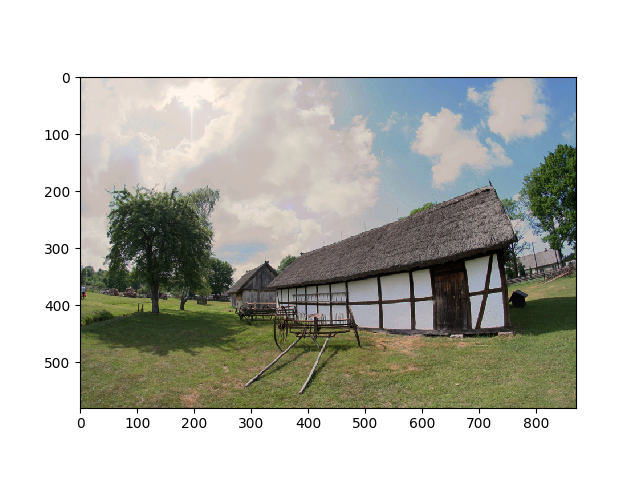

In [13]:
gamma = 0.4

result2 = np.power(result1/255., 1.0/gamma)
base_img = imgs[n//2]
for c in range(channel):
    result2[:,:,c] *= base_img[:,:,c].sum() / result2[:,:,c].sum()

result2 -= result2.min()
result2 *= 255./result2.max()

plt.figure(channel+2)
plt.imshow(result2.astype(np.uint8))

## Part II Drop the assumption that exposure is known

Consider 
$$w(z_{i,j})[g(z_{i,j} - \log E_i - \log t_j]$$

We used to used it as 
$$ w(z_{i,j}) g(z_{i,j}) - w(z_{i,j}) \log E_i  = w(z_{i,j}) \log t_j $$

in 
$$Ax = b$$

Now, $t_j$ is unknown, so use it as 
$$ w(z_{i,j}) g(z_{i,j}) - w(z_{i,j}) \log E_i  - w(z_{i,j}) \log t_j = 0$$

and add $\{\log t_j\}$ in to $x$

So we get our new ``gsolve``

In [38]:
def gslove2(Z,l,w,Z_min,Z_max): # Based on Debevec and Malik's 21 line MATLAB
    m = Z.shape[1] # the number of pictures, global n
    n = Z_max - Z_min +1
    s = Z.shape[0] # the number of pixels
    A = np.zeros((s*m+n+2, n+s+m))
    b = np.zeros((A.shape[0],1))
    k = 0  
    # Include the data−fitting equations
    for i in range(s):
        for j in range(m):
            wij = w[Z[i,j]]
            A[k,Z[i,j]] = wij; A[k,n+i] = -wij; A[k,n+s+j] = -wij
            k += 1
    # Fix the curve by setting its middle value to 0
    A[k,n//2] = 1
    k+=1
    
    A[k, n+s+m//2] = 10000
    k+=1
    
    A[k, n+s] = 10000
    b[k,0] = -10000 # otherwise trivial solution x=0
    k+=1 
    # Include the smoothness equations
    
    for i in range(n-1):
        A[k,i:i+3] = l * w[i+1] * np.array([1,-2,1])
        k+=1
    
    # Solve the system
    x = np.linalg.lstsq(A,b)[0]
    
    g  = x[0:n  ,0]
    lE = x[n:n+s,0]
    lt = x[n+s: ,0]
    
    return (g,lE,lt)

Then we do every thing again

<IPython.core.display.Javascript object>


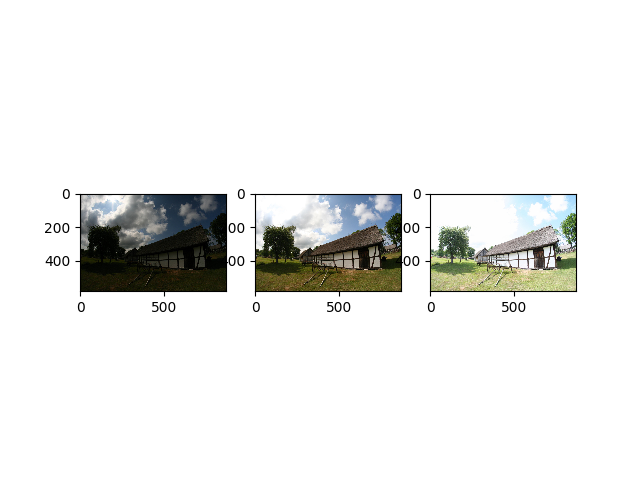

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


log t_j: [-9.99902704e-01 -9.72955060e-05  8.15425608e-01]


<IPython.core.display.Javascript object>


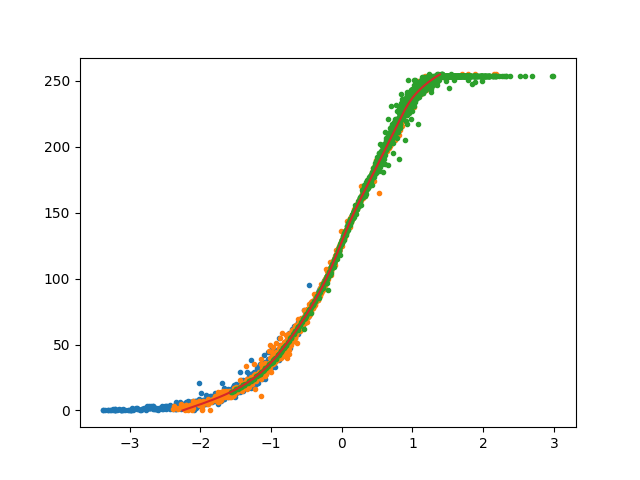

log t_j: [-9.99896552e-01 -1.03448318e-04  8.19412761e-01]


<IPython.core.display.Javascript object>


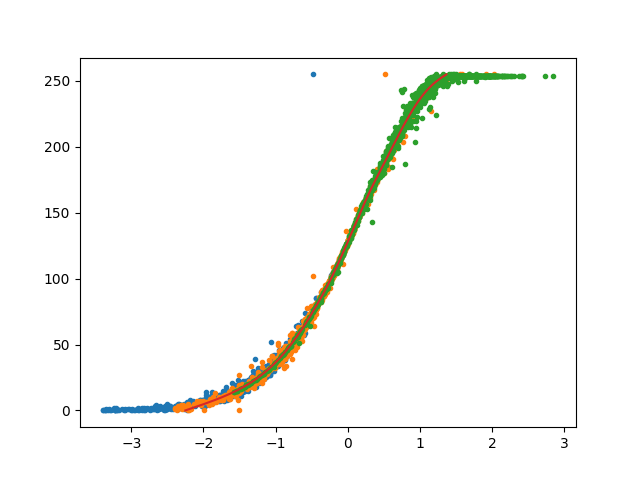

log t_j: [-9.99911691e-01 -8.83086026e-05  8.23346538e-01]


<IPython.core.display.Javascript object>


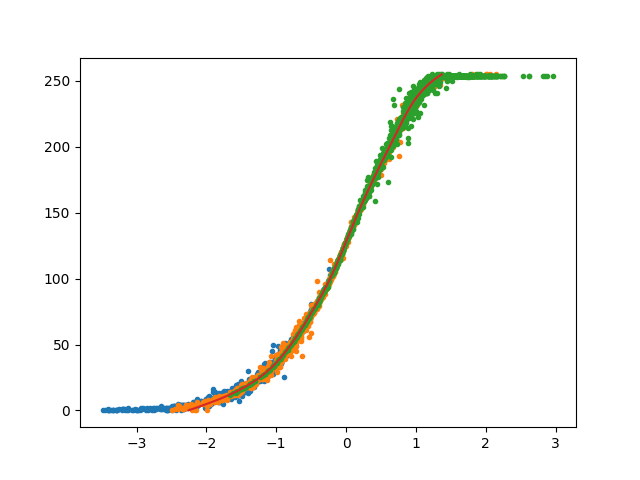

In [40]:
plt.figure()
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.imshow(imgs[i])

z_min = 0
z_max = 255
w = np.array(range(z_max+1))
w = np.minimum(w-z_min, z_max-w)
gs = np.zeros((channel,z_max-z_min+1))

for c in range(channel):
    sample = MySampleIntensities(imgs[:,:,:,0],z_min,z_max)
    g,lE,lt = gslove2(sample, 128., w, z_min, z_max )
    print('log t_j:',lt)
    #g,lE = gslove(sample,log_exposure_time, 128., w, z_min, z_max )
    
    
    plt.figure()
    for j in range(sample.shape[1]):
        plt.plot(lE+lt[j],sample[:,j],'.')
    
    plt.plot(g,range(g.shape[0]))
    gs[c] = g

plt.show()

<IPython.core.display.Javascript object>


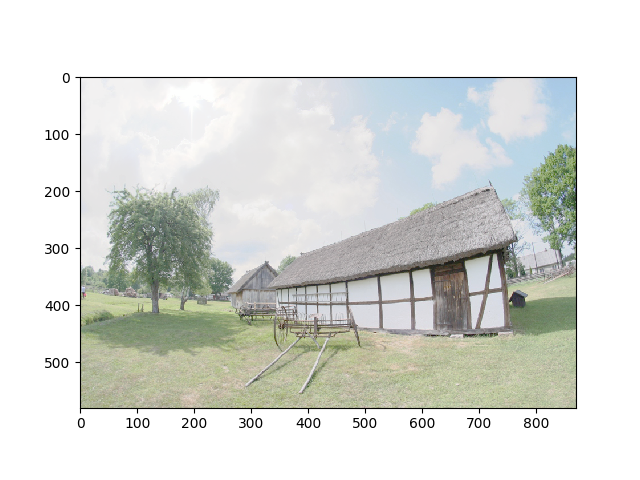

<IPython.core.display.Javascript object>


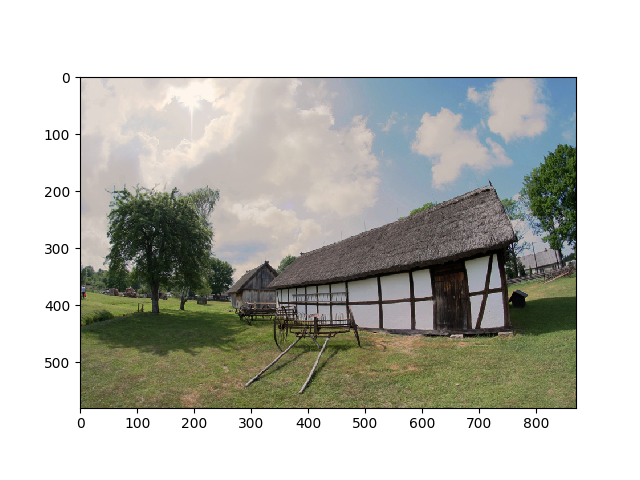

In [34]:
result = np.zeros((ih,iw,channel))

for c in range(channel):
    g = gs[c]

    logE = np.zeros((ih,iw))
    ww = np.exp(g) / np.gradient(g)

    for x in range(ih):
        for y in range(iw):
            logE[x,y] = ((ww[imgs[:,x,y,c]] * g[imgs[:,x,y,c]] - lT)).sum() / ww[imgs[:,x,y,c]].sum()
    result[:,:,c] = logE
    
    
plt.figure()

result1 = result - result.min()
result1 *= 255. / result1.max()

plt.imshow(result1.astype(np.uint8))

gamma = 0.4

result2 = np.power(result1/255., 1.0/gamma)
base_img = imgs[n//2]
for c in range(channel):
    result2[:,:,c] *= base_img[:,:,c].sum() / result2[:,:,c].sum()

result2 -= result2.min()
result2 *= 255./result2.max()

plt.figure()
plt.imshow(result2.astype(np.uint8))